# Prompt Tuning 实战

# 原理介绍：

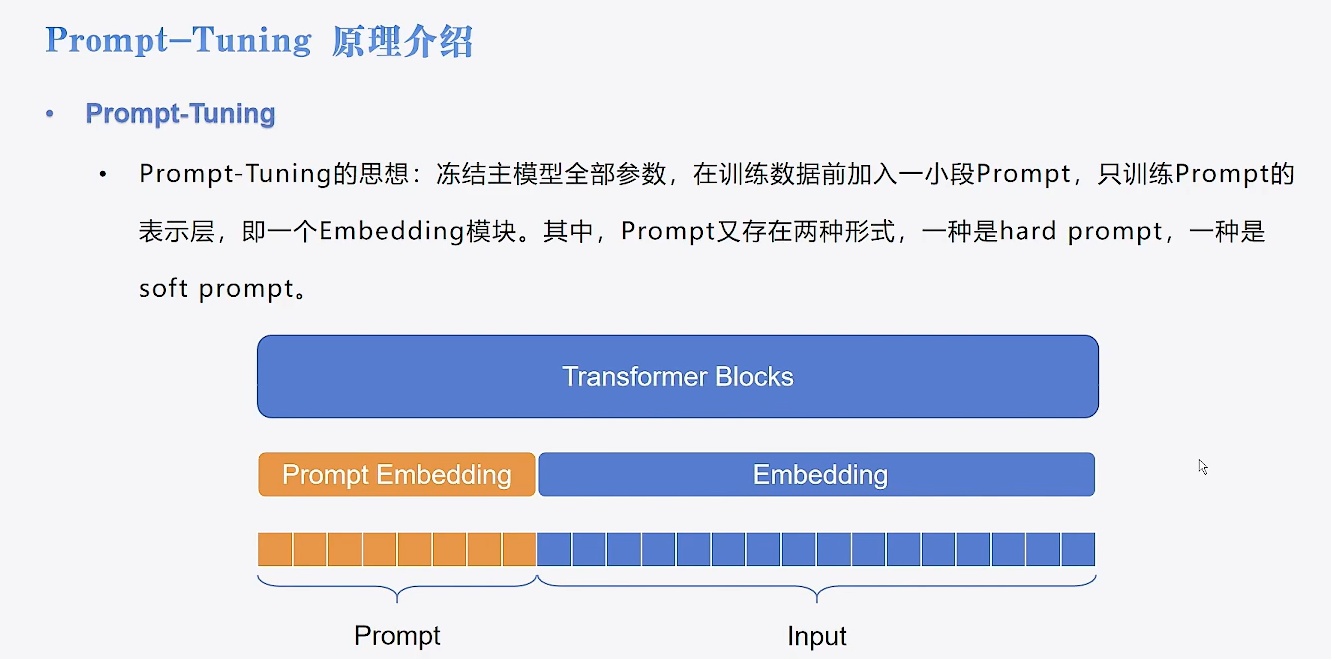

prompt是一种提示、引导。

hard prompt：人工描述的提示语

soft prompt：不指定初始的自然语言,机器自己学

环境配置

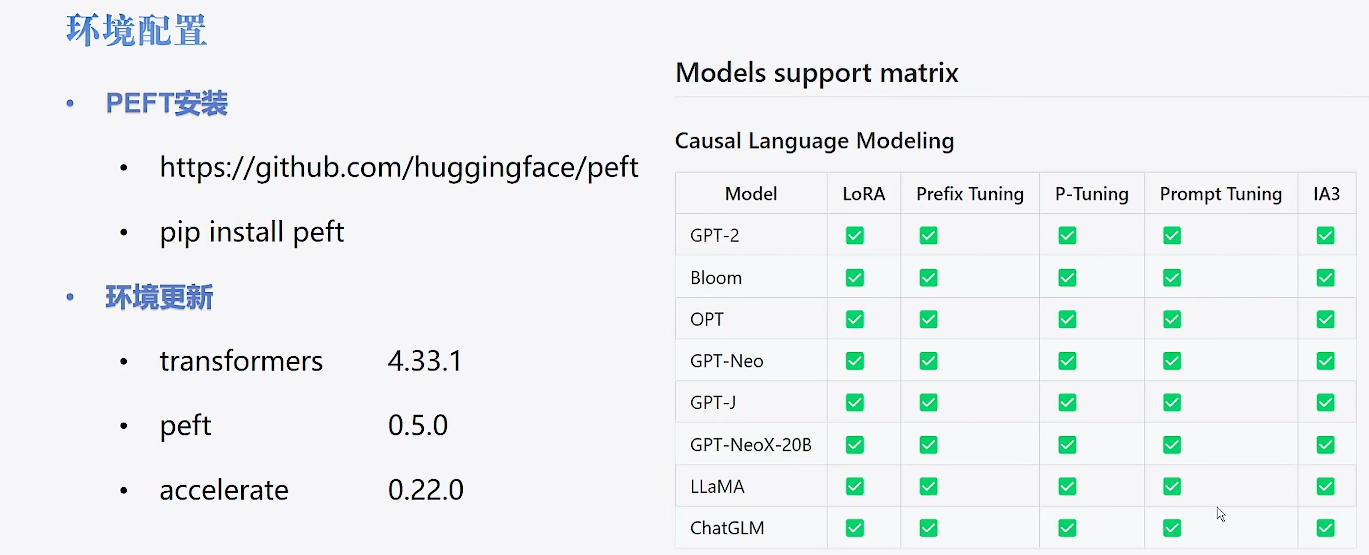

## Step1 导入相关包

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 加载数据集

In [2]:
ds = Dataset.load_from_disk("../data/alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
ds[:3]

{'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
  '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。',
  '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。'],
 'input': ['', '输入：4/16', ''],
 'instruction': ['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']}

## Step3 数据集预处理

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-389m-zh")
tokenizer

BloomTokenizerFast(name_or_path='Langboat/bloom-389m-zh', vocab_size=42437, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [6]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [23]:
tokenizer.decode(tokenized_ds[1]["input_ids"])

'Human: 解释为什么以下分数等同于1/4\n输入：4/16\n\nAssistant: 4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。</s>'

In [24]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

'4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。</s>'

## Step4 创建模型

In [35]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-389m-zh", low_cpu_mem_usage=True)

## Prompt tuning

### PEFT Step1 配置文件

In [34]:
from peft import PromptTuningConfig, get_peft_model, TaskType, PromptTuningInit

# Soft Prompt
# config = PromptTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=10)

#  Overview of the supported task types:
    # - SEQ_CLS: Text classification.
    # - SEQ_2_SEQ_LM: Sequence-to-sequence language modeling.
    # - CAUSAL_LM: Causal language modeling.
    # - TOKEN_CLS: Token classification.
    # - QUESTION_ANS: Question answering.

# prompt_tuning_init (Union[[`PromptTuningInit`], `str`]): The initialization of the prompt embedding.
        # prompt_tuning_init_text (`str`, *optional*):
        #     The text to initialize the prompt embedding. Only used if `prompt_tuning_init` is `TEXT
# num_virtual_tokens (`int`): The number of virtual tokens to use.

# Hard Prompt
config = PromptTuningConfig(task_type=TaskType.CAUSAL_LM,
                            prompt_tuning_init=PromptTuningInit.TEXT,
                            prompt_tuning_init_text="下面是一段人与机器人的对话。",
                            num_virtual_tokens=len(tokenizer("下面是一段人与机器人的对话。")["input_ids"]),
                            tokenizer_name_or_path="Langboat/bloom-389m-zh")
config

PromptTuningConfig(peft_type=<PeftType.PROMPT_TUNING: 'PROMPT_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=8, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, prompt_tuning_init=<PromptTuningInit.TEXT: 'TEXT'>, prompt_tuning_init_text='下面是一段人与机器人的对话。', tokenizer_name_or_path='Langboat/bloom-389m-zh', tokenizer_kwargs=None)

In [10]:
# Soft Prompt
config = PromptTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=10)

### PEFT Step2 创建模型

In [36]:
model = get_peft_model(model, config)

In [37]:
model
# 这就是一个PEFT的model了，PeftModelForCausalLM，

PeftModelForCausalLM(
  (base_model): BloomForCausalLM(
    (transformer): BloomModel(
      (word_embeddings): Embedding(42437, 1024)
      (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (h): ModuleList(
        (0-23): 24 x BloomBlock(
          (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (self_attention): BloomAttention(
            (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (attention_dropout): Dropout(p=0.0, inplace=False)
          )
          (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BloomMLP(
            (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu_impl): BloomGelu()
            (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
          )
        )
      )

In [38]:
model.print_trainable_parameters() # 可训练参数

trainable params: 8,192 || all params: 345,777,152 || trainable%: 0.002369155958575308


## Step5 配置训练参数

In [14]:
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1,
    save_steps=20,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Step6 创建训练器

In [39]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Step7 模型训练

In [40]:
trainer.train()
# soft max训练时loss下降很慢

Step,Training Loss
10,3.275500
20,3.434300
30,3.287000
40,3.242000
50,3.281600
60,3.318300
70,3.122700
80,3.097400
90,3.144000
100,3.043100


Checkpoint destination directory ./chatbot/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./chatbot/checkpoint-40 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./chatbot/checkpoint-60 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./chatbot/checkpoint-80 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./chatbot/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./chatbot/checkpoint-120 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./chatbot/checkpoint-140 already exists and is non-empty. Saving will proceed but saved results may b

KeyboardInterrupt: 

## 加载训练好的PEFT模型

In [18]:
from peft import PeftModel

In [45]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-389m-zh", low_cpu_mem_usage=True)
# 要重新，直接加载预训练模型

In [46]:
peft_model = PeftModel.from_pretrained(model=model, model_id="./chatbot/checkpoint-200/")
# 加载peft参数

In [22]:
peft_model

PeftModelForCausalLM(
  (base_model): PeftModelForCausalLM(
    (base_model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(42437, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): BloomMLP(
              (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu_impl): BloomGelu()
              (dense_4h_to_h): Linear(in_fe

## Step8 模型推理

In [42]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(peft_model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 准备一个主题，包括一些选项，以便能够帮助考生分析问题和回答问题。你可以使用与题意相关的词语，例如“有”、“能”、“该”等。
考试技巧一般包括以下类型：
（1）选择题
（1）选择题通常包括一连串答案；根据选择的选项，您将从选择题中获得一些“经验”。
（1）选择题通常包括一连串答案；根据选择的选项，您将得到许多“经验”。在这种情况下，您可以选择“经验”和“经验”之间的区别来判断选择问题。该选项与“


In [48]:
peft_model = peft_model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(peft_model.device)
print(tokenizer.decode(peft_model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 考试应该按照一定的顺序，首先是个人陈述及分析类的题目，然后就是个人讨论类题目。再后，就是社会调查类的题目和案例分析类题目。最后，大家一起讨论和交换对问题进行参考。
答: 个人陈述和案例分析类的题目要尽量写在题目里面，在写上个人陈述的时候，应该与题目无关，而需要跟所讨论的热点话题联系在一起，而不是把所讨论的背景与所写的题目无关。另外，个人陈述的时候应该不要把自己分析的案例与平时所学习的案例直接和题
